In [1]:
!pip install casadi
from IPython.display import clear_output
import os

import numpy as np
import casadi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

os.makedirs('images',exist_ok=True)
if os.name == 'nt':
    plt.rcParams['font.family'] = 'MS Gothic'
elif os.name == 'posix':
    !pip install japanize-matplotlib


clear_output()

# 定数

In [2]:
Cn = 360

nx = 2 #状態変数の次元
nu = 1 #制御変数の次元
nw = nx #プロセスノイズの次元
ny = 1 #観測変数の次元
nv = ny # 観測ノイズ

# 後退ホライズン等
T = 6
K = 60
dt = T/K

#コスト行列
Q_i = casadi.diag([0.01,0.01])
Q = casadi.diag([100,100])
R = casadi.diag([100])

# 制約条件
x_lb = [0,-np.inf]
x_ub = [1,np.inf]
w_lb = [-np.inf,-np.inf]
w_ub = [np.inf,np.inf]
v_lb = [-np.inf]
v_ub = [np.inf]

total = nx*(K+1) + nw*K + nu*K + ny*K + nv*K + nx

# 状態方程式・観測方程式・積分器・コスト関数

In [3]:
def make_f():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)
    pnoises = casadi.SX.sym("pnoises",nw)

    soc = states[0]
    V1 = states[1]
    I = ctrls[0]

    R1 = 7.74*soc**5 - 16.88*soc**4 + 13.00*soc**3 - 4.17*soc**2 + 0.507*soc + 0.0027
    C1 = 124589.17*soc**5 - 203175.87*soc**4 + 92495.58*soc**3 - 644.92*soc**2 - 6863.34*soc + 1877.26

    soc_dot = -I/Cn
    V1_dot = I/C1 - V1/(R1*C1)

    states_dot = casadi.vertcat(soc_dot,V1_dot) + pnoises

    f = casadi.Function("f",[states,ctrls,pnoises],[states_dot],['x','u',"w"],['x_dot'])
    return f

def make_F_RK4():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)
    pnoises = casadi.SX.sym("pnoises",nw)

    f = make_f()

    k1 = f(x=states,u=ctrls,w=pnoises)["x_dot"]
    k2 = f(x=states+dt*k1/2,u=ctrls,w=pnoises)["x_dot"]
    k3 = f(x=states+dt*k2/2,u=ctrls,w=pnoises)["x_dot"]
    k4 = f(x=states+dt*k3,u=ctrls,w=pnoises)["x_dot"]

    states_next = states + dt*(k1+2*k2+2*k3+k4)/6

    F_RK4 = casadi.Function("F_RK4",[states,ctrls,pnoises],[states_next],["x","u","w"],["x_next"])
    return F_RK4

def make_h():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)
    onoises = casadi.SX.sym("onoises",nv)

    soc = states[0]
    V1 = states[1]
    I = ctrls[0]

    Voc = 6.22*soc**5 - 19.91*soc**4 + 23.98*soc**3 - 12.66*soc**2 + 3.29*soc + 3.24
    R0 = -0.638*soc**5 + 1.63*soc**4 - 1.60*soc**3 + 0.774*soc**2 - 0.187*soc + 0.089

    observes = Voc - R0*I - V1 + onoises

    h = casadi.Function("h",[states,ctrls,onoises],[observes],['x',"u","v"],['y'])
    return h

def make_integrator():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)
    pnoises = casadi.SX.sym("pnoises",nw)

    f = make_f()
    ode = f(x=states, u=ctrls,w=pnoises)["x_dot"]
    params = casadi.vertcat(ctrls,pnoises)
    dae = {"x":states,"p":params,"ode":ode}

    I = casadi.integrator("I","cvodes",dae,0,dt)
    return I

def compute_stage_cost(w,v):
    cost = (casadi.dot(Q@w,w) + casadi.dot(R@v,v)) / 2
    return cost

def compute_initial_cost(x_diff):
    cost = casadi.dot(Q_i@x_diff,x_diff) / 2
    return cost

# 最適化問題

In [4]:
def make_nlp():
    F_RK4 = make_F_RK4()
    h = make_h()

    X = [casadi.SX.sym(f"x_{i}",nx) for i in range(K+1)]
    U = [casadi.SX.sym(f"u_{i}",nu) for i in range(K)]
    Y = [casadi.SX.sym(f"y_{i}",ny) for i in range(K)]
    W = [casadi.SX.sym(f"w_{i}",nw) for i in range(K)]
    V = [casadi.SX.sym(f"w_{i}",nv) for i in range(K)]
    x_hat = casadi.SX.sym("x_hat",nx)
    G = []

    J = 0
    x_diff = X[0] - x_hat
    J += compute_initial_cost(x_diff)
    for k in range(K):
        J += compute_stage_cost(W[k],V[k]) * dt
        state_eq = X[k+1] - F_RK4(x=X[k],u=U[k],w=W[k])["x_next"]
        obs_eq = Y[k] - h(x=X[k],u=U[k],v=V[k])["y"]
        G.append(state_eq)
        G.append(obs_eq)

    option = {'print_time':False,'ipopt':{'max_iter':1000,'print_level':0}}
    nlp = {"x":casadi.vertcat(*X,*W,*U,*Y,*V,x_hat),"f":J,"g":casadi.vertcat(*G)}
    S = casadi.nlpsol("S","ipopt",nlp,option)
    return S

# 状態推定の計算

In [5]:
def compute_optimal_estimation(S,us,ys,x0,x_hat):
    lbx = x_lb*(K+1) + w_lb*K + us + ys + v_lb*K + x_hat
    ubx = x_ub*(K+1) + w_ub*K + us + ys + v_ub*K + x_hat
    lbg = ([0]*nx + [0]*ny)*K
    ubg = ([0]*nx + [0]*ny)*K

    res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)
    
    # offset = nx*(N+1)
    x0 = res["x"]
    return x0

# MHE

In [6]:
S = make_nlp()

# 初期値の用意

In [28]:
def make_x0(x_hat):
    I = make_integrator()
    h = make_h()
    x0 = [x_hat]
    y0 = []
    x_tmp = x_hat
    for i in range(K):
        x_tmp = I(x0=x_tmp)["xf"]
        y_tmp = h(x=x_tmp)["y"]
        x0.append(x_tmp)
        y0.append(y_tmp)
    w0 = casadi.DM.zeros(nw*K)
    u0 = casadi.DM.zeros(nu*K)
    v0 = casadi.DM.zeros(nv*K)
    x0 = casadi.vertcat(*x0,w0,u0,*y0,v0,x_hat)
    return x0

In [31]:
t_span = [0,60]
t_eval = np.arange(*t_span,dt)

I = make_integrator()
h = make_h()

x_init = casadi.DM([0.8,4]) # 初期値
# u_init = casadi.DM.zeros(nu)
# y_init = h(x=x_init,u=u_init)["y"]

x_hat = casadi.DM([0.4,0]) * 0
x0 = make_x0(x_hat)
x0 = casadi.DM.zeros(total)

CHARGE = False

X = [x_init]
X_est = [x_hat]
U = []
Y = []
x_current = x_init
for t in t_eval:
    if len(Y) >= K:
        ys = casadi.vertcat(*Y[-K:]).full().ravel().tolist()
        us = casadi.vertcat(*U[-K:]).full().ravel().tolist()
        x_hat_list = x_hat.full().ravel().tolist()
        x0 = compute_optimal_estimation(S,us,ys,x0,x_hat_list)
        x_hat = x0[:nx]
        X_est.append(x_hat)
    if CHARGE:
        if x_current[0] > 0.8:
            CHARGE = False
            u_current = np.zeros(nu)
        else:
            u_current = np.array([-10])
    else:
        if x_current[0] < 0.2:
            CHARGE = True
            u_current = np.array([-10])
        else:
            u_current = np.random.uniform(0,30,size=nu)
    w_current = np.random.normal(scale=1e-3,size=(nw,))
    v_current = np.random.normal(scale=1e-3,size=(nv,))
    p_current = casadi.DM([*u_current,*w_current])
    y_current = h(x=x_current,u=u_current,v=v_current)["y"]
    x_current = I(x0=x_current,p=p_current)["xf"]
    X.append(x_current)
    Y.append(y_current)
    U.append(u_current)

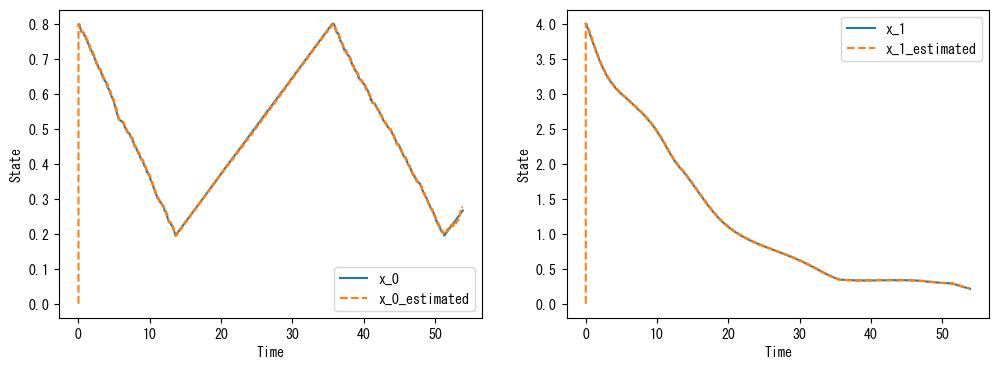

In [32]:
X.pop()
X = np.array(X).reshape(t_eval.size,nx)
X_est.pop()
X_est = np.array(X_est).reshape(-1,nx)

plt.figure(figsize=(12,4))

for i in range(nx):
    plt.subplot(1,2,i+1)
    plt.plot(t_eval[:-K],X[:-K,i],label=f"x_{i}")
    plt.step(t_eval[:-K],X_est[:,i],linestyle="--",label=f"x_{i}_estimated")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("State")

plt.savefig("images/chap8_LIB_MHE.pdf")
plt.show()